In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from src.models.ConvAttentionModel import ConvAttentionModel
from src.models.AttentionAttentionModel import AttentionAttentionModel
from src.visualization.loss_and_metrics import draw_loss_and_metrics, compare_losses

%matplotlib inline
%config InlineBackend.figure_format='retina'

/Users/ilyamikheev/Desktop/projects/selected-topics-ai/INDUCTION-HEADS-WITH-CONVOLUTIONS/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




### Архитектуры моделей

Первая модель:

$\text{Embeddings} + \text{Absolute Positional Embeddings} \rightarrow \text{SDPA} \rightarrow \text{SDPA} \rightarrow \text{LinearOutput}$

Вторая модель:

$\text{Embeddings} + \text{Absolute Positional Embeddings} \rightarrow \text{CausalConvolution} \rightarrow \text{SDPA} \rightarrow \text{LinearOutput}$

#### Параметры моделей

Размеры эмбеддингов $768$, количество голов внимания $12$ на блок.



### Параметры обучения

В качестве оптимизатора был взят $AdamW$, начальный $lr=3e-4$, размер батча 4, ограничение на максимальную длину последовательности $512$. Количество эпох $10$, размер тренировочного набора данных $50000$.



Графики обучения моделей

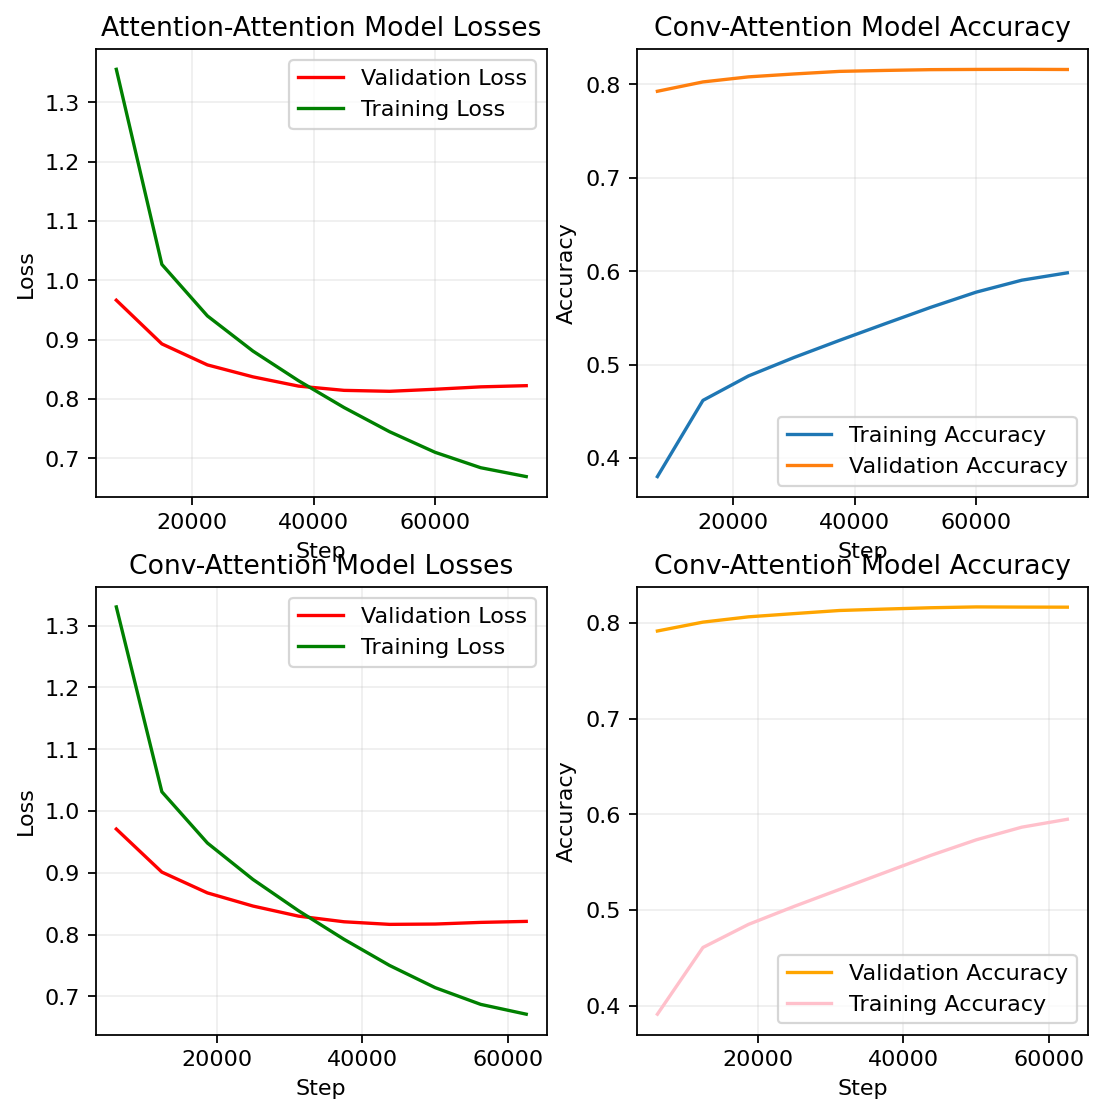

In [4]:
draw_loss_and_metrics()

В коде подсчета метрик для валидации похоже есть ошибка, но я так и не смог ее найти ¯\\_(ツ)_/¯

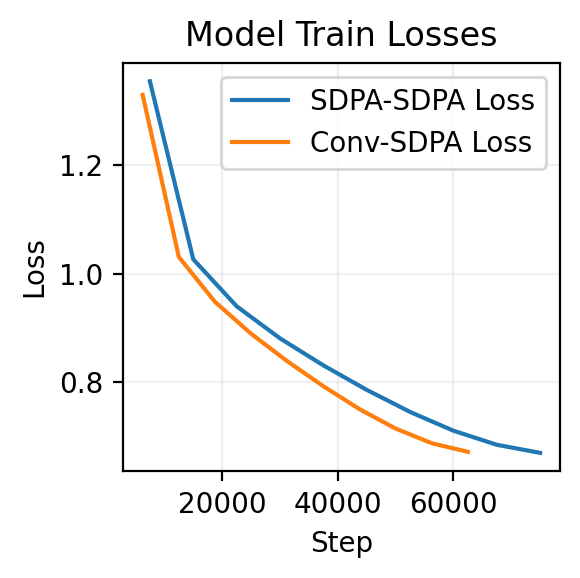

In [5]:
compare_losses()

Лоссы получились у очень близкими. Но модель со свертками обучалась чуть лучше.

Кстати это случилось не сразу, по началу вторую модель просто взрывало по-середине обучения. Я заклипил норму градиентов на $0.8$ после этого более менее начало сходиться.

### Посмотрим на карты внимания

In [6]:
text = "Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. Mr Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large moustache. Mrs Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbours. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere. The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn't think they could bear it if anyone found out about the Potters. Mrs Potter was Mrs Dursley's sister, but they hadn't met for several years; in fact, Mrs Dursley pretended she didn't have a sister, because her sister and her good- for-nothing husband were as unDursleyish as it was possible to be. The Dursleys shuddered to think what the neighbours would say if the Potters arrived in the street. The Dursleys knew that the Potters had a small son, too, but they had never even seen him. This boy was another good reason for keeping the Potters away; they didn't want Dudley mixing with a child like that.\n\nMr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. Mr Dursley was the director of a firm called Grunnings, which made drills."

In [6]:
tokenizer_name = "gpt2"
max_seq_length = 512
embedding_dim = 768
attention_heads_per_layer = 12


tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
input = tokenizer(text, return_tensors="pt", return_attention_mask=True)


sdpa_sdpa_model = AttentionAttentionModel(
    vocab_size=tokenizer.vocab_size,
    emb_dim=embedding_dim,
    attention_heads_per_layer=attention_heads_per_layer,
    max_seq_length=max_seq_length,
)

sdpa_sdpa_model.load_state_dict(torch.load("../src/train/model_checkpoints/checkpoint_epoch_10_20250424_165701.pt")["model_state_dict"])


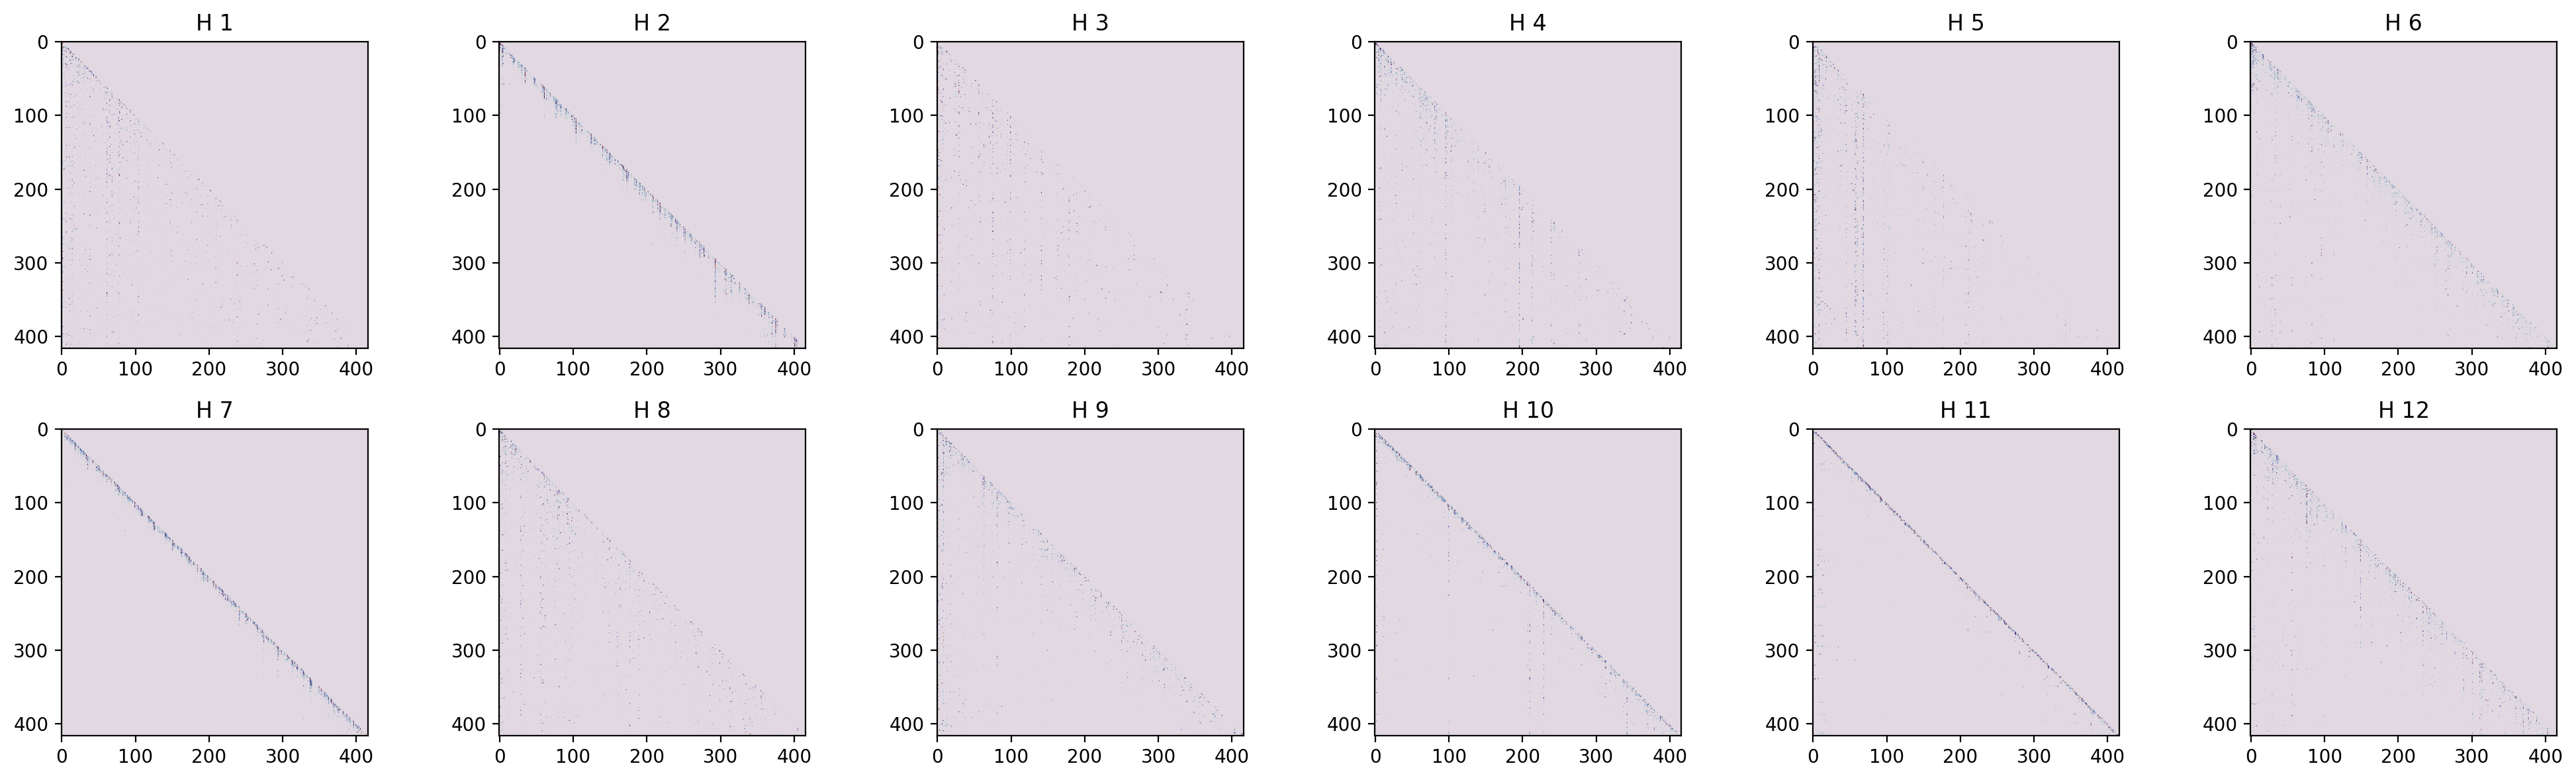

In [60]:
fig, ax = plt.subplots(figsize=(20, 6), nrows=2, ncols=6)
axs = ax.flatten()

plt.title("Карты внимания со второго слоя для SDPA-SDPA модели")

for i, ax in enumerate(axs):

    weights_to_plot = attn_weights[0, i].detach().cpu().numpy()
    ax.imshow(weights_to_plot, cmap='twilight')
    ax.set_title(f"H {i+1}")

plt.tight_layout()
plt.show()

In [8]:

conv_attn_model = ConvAttentionModel(
    vocab_size=tokenizer.vocab_size,
    emb_dim=embedding_dim,
    attention_heads_per_layer=attention_heads_per_layer,
    max_seq_length=max_seq_length,
)

conv_attn_model.load_state_dict(torch.load("../src/train/model_checkpoints/checkpoint_epoch_10_20250424_082722.pt")["model_state_dict"])

logits, attn_weights = conv_attn_model(input_ids=input["input_ids"], attention_mask=input["attention_mask"])

In [10]:
logits, attn_weights = conv_attn_model(input_ids=input["input_ids"], attention_mask=input["attention_mask"])

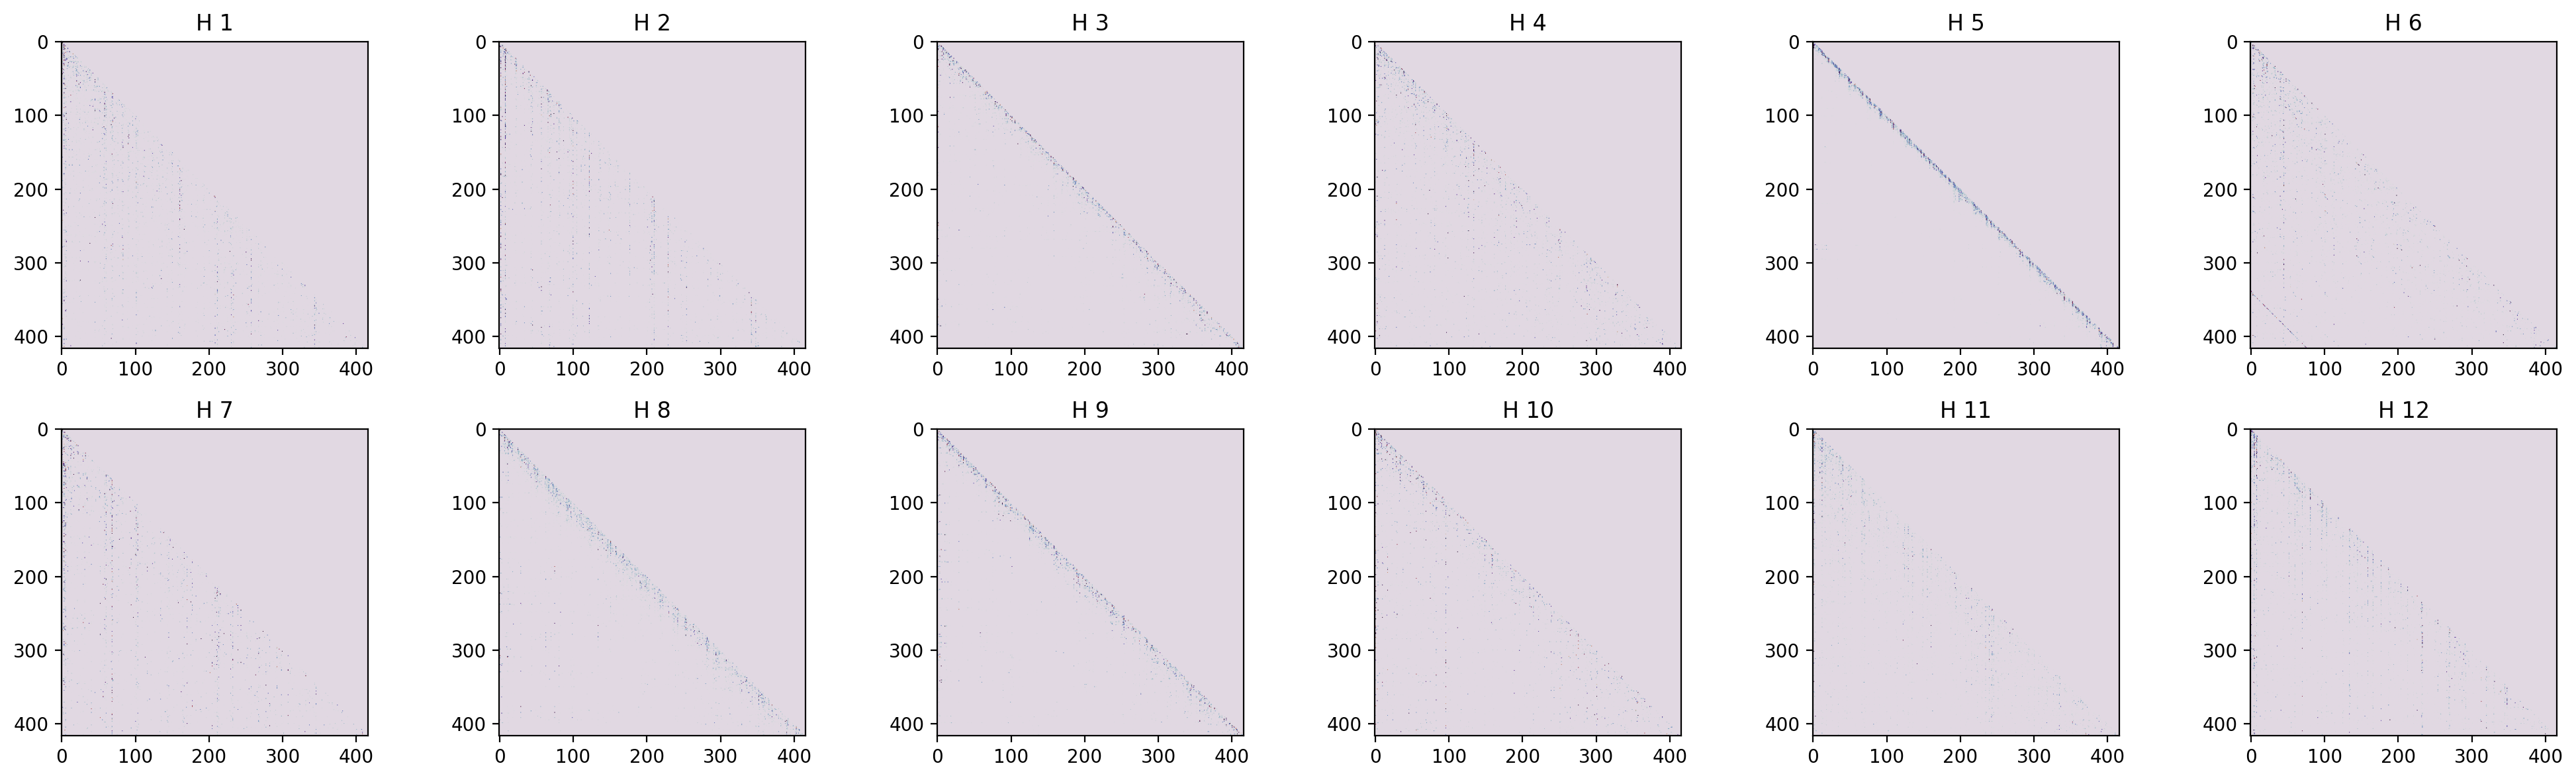

In [11]:
fig, ax = plt.subplots(figsize=(20, 6), nrows=2, ncols=6)
axs = ax.flatten()

plt.title("Карты внимания со второго слоя для SDPA-SDPA модели")

for i, ax in enumerate(axs):

    weights_to_plot = attn_weights[0, i].detach().cpu().numpy()
    ax.imshow(weights_to_plot, cmap='twilight')
    ax.set_title(f"H {i+1}")

plt.tight_layout()
plt.show()

В модели со сверткой появилась голова ($H6$)

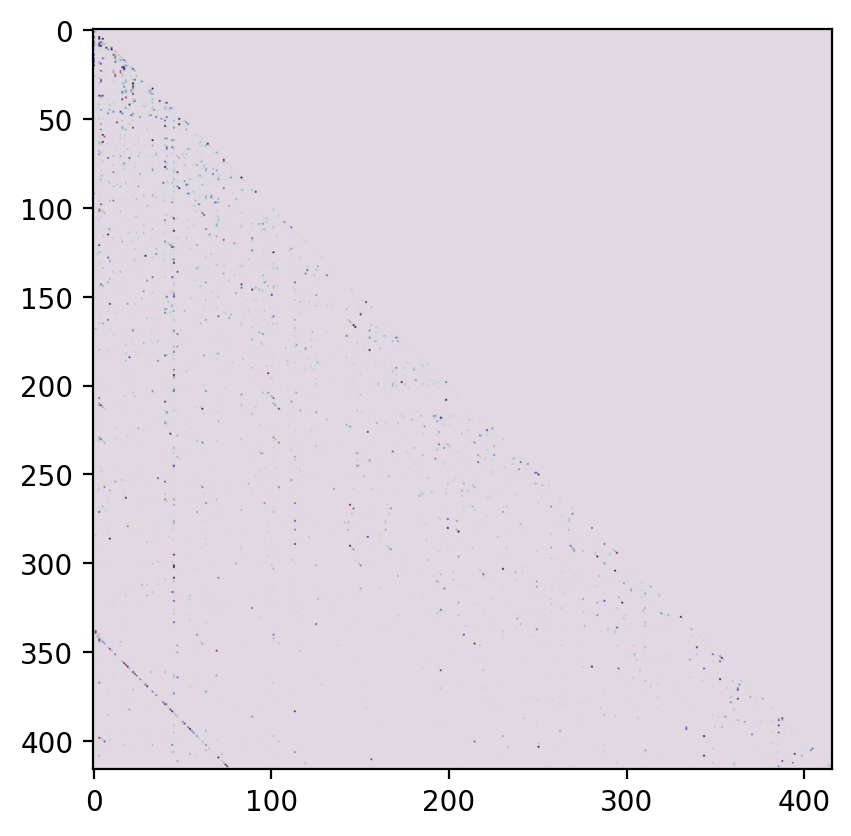

In [15]:
plt.imshow(attn_weights[0, 5].detach().cpu().numpy(), cmap='twilight')
plt.show()

In [ ]:
В модели со сверткой